### Clinical Drift Detection

In [1]:
import datetime
import numpy as np
import os
from cyclops.utils.file import load_pickle, save_pickle
from drift_detection.drift_detector.clinical_applicator import ClinicalShiftApplicator
from drift_detection.drift_detector.detector import Detector
from drift_detection.drift_detector.experimenter import Experimenter
from drift_detection.drift_detector.plotter import plot_drift_samples_pval
from drift_detection.drift_detector.reductor import Reductor
from drift_detection.drift_detector.tester import DCTester, TSTester
from drift_detection.gemini.utils import import_dataset_hospital
from drift_detection.gemini.constants import DIAGNOSIS_DICT, ACADEMIC, COMMUNITY, HOSPITALS
from drift_detection.gemini.utils import get_use_case_params, impute, get_source_target
from models.temporal.utils import (
    get_device,
)
from drift_detection.drift_detector.plotter import plot_drift_samples_pval

## Config Parameters ##

In [2]:
DATASET = "gemini"
USE_CASE = "mortality"
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/" 
SHIFT = input("Select experiment: ") 
DIAGNOSIS_TRAJECTORY = input("Select diagnosis_trajectory: ") 
if DIAGNOSIS_TRAJECTORY == "":
    ID = SHIFT
else:
    diagnosis_trajectory = '_'.join(DIAGNOSIS_DICT[DIAGNOSIS_TRAJECTORY])
    ID = SHIFT+"_"+ diagnosis_trajectory
    
MODEL_PATH = os.path.join(
    PATH,
    DATASET,
    USE_CASE,
    "saved_models",
    ID + "_reweight_positive_lstm.pt"
)

Select experiment:  female
Select diagnosis_trajectory:  


## Query Data ##

In [3]:
use_case_params = get_use_case_params(DATASET, USE_CASE)

(X_tr_final, y_tr), (X_val_final, y_val), (X_t_final, y_t) = import_dataset_hospital(
    use_case_params.TAB_VEC_COMB, ID, train_frac=0.8, shuffle=True,
)

2022-11-28 11:20:16,063 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_female.pkl
2022-11-28 11:20:21,539 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_female.pkl
2022-11-28 11:20:21,963 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_female.pkl
2022-11-28 11:20:24,306 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_female.pkl
2022-11-28 11:20:24,495 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_female.pkl
2022-11-28 11:20:26,073 INFO cyclops.utils.file - Loading pickled

## Reductor

In [4]:
DR_TECHNIQUE = input("Select dimensionality reduction technique: ")

reductor = Reductor(
    dr_method=DR_TECHNIQUE,
    model_path=MODEL_PATH,
    n_features=X_tr_final.shape[2],
    var_ret=0.8,
)

Select dimensionality reduction technique:  BBSDs_trained_LSTM


Loading model...


## Tester

In [5]:
TESTER_METHOD = input("Select test method: ")
tstesters=["lk", "lsdd", "mmd", "tabular", "ctx_mmd","chi2", "fet", "ks" ]
CONTEXT_TYPE=None
REPRESENTATION=None
dctesters =["spot_the_diff", "classifier", "classifier_uncertainty"]

if TESTER_METHOD in tstesters:
    tester = TSTester(
        tester_method=TESTER_METHOD,
    )
    if TESTER_METHOD == "ctx_mmd":
        CONTEXT_TYPE = input("Select context type: ")
        
elif TESTER_METHOD in dctesters:
    MODEL_METHOD = input("Select model method: ")
    tester = DCTester(
        tester_method=TESTER_METHOD,
        model_method=MODEL_METHOD,
    )
        
    if TESTER_METHOD == "lk":
        REPRESENTATION = input("Select learned kernel representation: ")
  

Select test method:  mmd


## Detector

In [20]:
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05
    
)
detector.fit(
    X_tr_final[:1000, :],
    backend="pytorch",
    device = "cuda",
    model_path = MODEL_PATH,
    batch_size=16,
    alternative="two-sided",
    n_permutations= 100,
    verbose=0,
)

## ClinicalShiftApplicator

In [21]:
tab_features = load_pickle(use_case_params.TAB_FEATURES_FILE)

#clinicalshiftapplicator = ClinicalShiftApplicator(
#    shift_type = exp_params['shift_type'],
#    admin_data = tab_features.data
    
#) 

experimenter = Experimenter(
    detector = detector,
    experiment_type = "sensitivity_test",
#    shiftapplicator = clinicalshiftapplicator,
)

2022-11-28 13:15:32,140 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/tab_features.pkl


## Experimenter

In [22]:
val_drift_results = experimenter.sensitivity_test(
    X_val_final,
    
)
test_drift_results = experimenter.sensitivity_test(
    X_t_final,
)
shift_results = {
    'baseline': val_drift_results,
    'experiment': test_drift_results
}

100%|██████████| 35/35 [36:40<00:00, 62.86s/it]


## Plot drift results

In [23]:
#shift_results_comm = shift_results

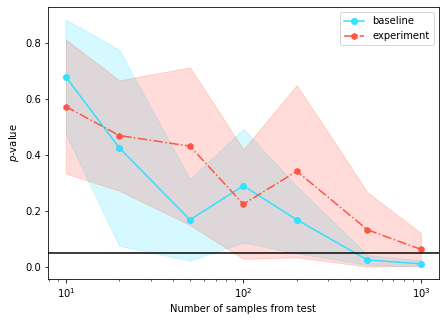

In [24]:
shift_results = {
    'baseline': val_drift_results,
    'experiment': test_drift_results
}
plot_drift_samples_pval(shift_results, 0.05)

In [17]:
results_path=os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join([ID, DR_TECHNIQUE,TESTER_METHOD])+'.pkl')
results_path

'/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/male_BBSDs_trained_LSTM_mmd.pkl'

In [18]:
shift_results

{'baseline': {'samples': [10, 20, 50, 100, 200, 500, 1000],
  'mean_p_vals': array([0.382     , 0.534     , 0.486     , 0.462     , 0.38999999,
         0.482     , 0.368     ]),
  'std_p_vals': array([0.10628264, 0.21795412, 0.29648609, 0.24652789, 0.23949947,
         0.26731255, 0.32089875]),
  'mean_dist': array([ 8.09316635e-03, -6.69318438e-03,  7.89988041e-04, -5.25784492e-04,
          8.74519348e-05,  1.60932541e-06,  1.89900398e-04]),
  'std_dist': array([0.01920287, 0.01134068, 0.00869772, 0.00236449, 0.00131468,
         0.00074503, 0.00046401])},
 'experiment': {'samples': [10, 20, 50, 100, 200, 500, 1000],
  'mean_p_vals': array([0.408     , 0.69400001, 0.38200001, 0.34600001, 0.66      ,
         0.682     , 0.652     ]),
  'std_p_vals': array([0.20448961, 0.20943734, 0.28805556, 0.29452335, 0.24657657,
         0.3224531 , 0.20439179]),
  'mean_dist': array([ 0.01633841, -0.01408848,  0.00395608,  0.00152839, -0.00118325,
         -0.0004029 , -0.00023807]),
  'std_dist

In [19]:
save_pickle(shift_results, results_path)

2022-11-28 04:16:47,883 INFO cyclops.utils.file - Pickling data to /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/male_BBSDs_trained_LSTM_mmd.pkl


'/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/male_BBSDs_trained_LSTM_mmd.pkl'

2022-11-26 20:40:28,706 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/hosp_type_academic_BBSDs_trained_LSTM_mmd.pkl
2022-11-26 20:40:28,709 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/hosp_type_community_BBSDs_trained_LSTM_mmd.pkl
2022-11-26 20:40:28,711 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/seasonal_summer_BBSDs_trained_LSTM_mmd.pkl
2022-11-26 20:40:28,713 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/seasonal_winter_BBSDs_trained_LSTM_mmd.pkl
2022-11-26 20:40:28,715 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/day_BBSDs_trained_LSTM_mmd.pkl
2022-11-26 20:40:28,717 INFO cyclops.utils.file - Loadi

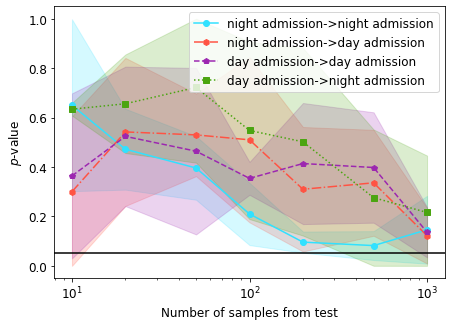

In [62]:
USE_CASE ="mortality"
DR_TECHNIQUE="BBSDs_trained_LSTM"
TESTER_METHOD="mmd"
partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["hosp_type_academic", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['academic->academic'] = partone['baseline']
partone['academic->community'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["hosp_type_community", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['community->community'] = parttwo['baseline']
parttwo['community->academic'] = parttwo['experiment']

partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["seasonal_summer", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['summer->summer'] = partone['baseline']
partone['summer->winter'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["seasonal_winter", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['winter->winter'] = parttwo['baseline']
parttwo['winter->summer'] = parttwo['experiment']
parttwo.update(partone)
parttwo.pop('baseline', None)
parttwo.pop('experiment', None)

partone = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["day", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
partone['day admission->day admission'] = partone['baseline']
partone['day admission->night admission'] = partone['experiment']
parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["night", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
parttwo['night admission->night admission'] = parttwo['baseline']
parttwo['night admission->day admission'] = parttwo['experiment']
parttwo.update(partone)
parttwo.pop('baseline', None)
parttwo.pop('experiment', None)

#parttwo = load_pickle(os.path.join(PATH,DATASET,USE_CASE,"drift",'_'.join(["not_nursing_home", DR_TECHNIQUE,TESTER_METHOD])+'.pkl'))
#parttwo['not from nursing home->not from nursing home'] = parttwo['baseline']
#parttwo['not from nursing home->from nursing home'] = parttwo['experiment']
#parttwo.pop('baseline', None)
#parttwo.pop('experiment', None)

def plot_drift_samples_pval(results, p_val_threshold):
    
    """Plot drift experiement p-values."""
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)

    for shift_iter, shift in enumerate(results.keys()):
        errorfill(
            results[shift]["samples"],
            results[shift]["mean_p_vals"],
            results[shift]["std_p_vals"],
            fmt=linestyles[shift_iter] + markers[shift_iter],
            color=colorscale(colors[shift_iter], brightness[shift_iter]),
            label=shift,
            ax=ax,
        )
    plt.xlabel("Number of samples from test")
    plt.ylabel("$p$-value")
    plt.axhline(y=p_val_threshold, color="k")
    plt.legend()
    #plt.rcParams.update({'font.size': 12})
    plt.show()


plot_drift_samples_pval(parttwo, 0.05)